In [135]:
import numpy as np

import pandas as pd

import xarray as xr

import glob

import matplotlib as mpl

import matplotlib.pyplot as plt

import math as mt

from math import e

import datetime

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from random import seed
from random import randint

from scipy.signal import hilbert
import statistics
from scipy.stats import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Read LMDZ files

In [20]:
#Read Orography
I_OroData = xr.open_dataset('../../../Data/LMDZ_Data/LMDZOR-Orography_remapedfromERA5.nc')
I_OroData.z.values=I_OroData.z.values/9.81

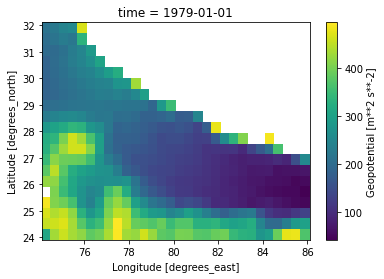

In [136]:

Ioro=I_OroData.z[0,:,:].sel(lat=slice(32,24),lon=slice(74,86))
Ioro
#Ioro.plot()
#Create Mask
Ioro.values[Ioro.values>500.1]=np.NaN
Imask=Ioro.values/Ioro.values
Ioro.plot()

# LMDZ T2m and T2m hilbert

In [137]:
I_t2mData= xr.open_dataset('../../../Data/LMDZ_Data/LMDZOR-HIST-t2m_DecJan_1979_2005_1D_histday.nc')

In [138]:
I_t2mData.time_counter
time1=I_t2mData.indexes['time_counter'].to_datetimeindex()
time1
I_t2mData=I_t2mData.assign_coords(time=("time_counter", time1))
#I_t2mData.t2m[0,:,:].plot()
It2mD = I_t2mData.sel(lat=slice(32,24),lon=slice(74,86))

<ipython-input-138-362ee5a88d20>:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  time1=I_t2mData.indexes['time_counter'].to_datetimeindex()


In [139]:
I_t2mData.assign_coords(time=("time_counter", time1))

<xarray.Dataset>
Dimensions:            (lat: 181, lon: 360, nb2: 2, time_counter: 1705)
Coordinates:
  * lon                (lon) float32 -178.9 -176.7 -174.3 ... 175.1 177.0 179.0
  * lat                (lat) float32 90.0 86.49 83.01 ... -82.91 -86.46 -90.0
  * time_counter       (time_counter) object 1978-12-01 12:00:00 ... 2005-12-...
    time               (time_counter) datetime64[ns] 1978-12-01T12:00:00 ... ...
Dimensions without coordinates: nb2
Data variables:
    time_counter_bnds  (time_counter, nb2) object ...
    t2m                (time_counter, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.6.3 (http://code.zmaw.de/p...
    Conventions:  CF-1.1
    history:      Thu Jan 28 10:21:17 2021: cdo mergetime LMDZOR-HIST-t2m_197...
    file_name:    histday.nc
    production:   An IPSL model
    TimeStamp:    2012-JUN-01 10:11:06 GMT+0530
    CDO:          Climate Data Operators version 1.6.3 (http://code.zmaw.de/p...

In [140]:
#Mask data
It2mD.t2m.values=It2mD.t2m.values*Imask
# area avg
It2mTS=It2mD.mean(dim=['lat','lon'], skipna=True).t2m
#ISelect only Dec Jan months
It2m=It2mTS[((It2mTS.time.dt.month>11) | (It2mTS.time.dt.month<2))]
#It2m.plot()

# LMDZ wind speed and wind speed hilbert

In [141]:
# Read data
Iu10Data = xr.open_dataset('../../../Data/LMDZ_Data/LMDZOR-HIST-u10m_DecJan_1979_2005_1D_histday.nc')
Iv10Data = xr.open_dataset('../../../Data/LMDZ_Data/LMDZOR-HIST-v10m_DecJan_1979_2005_1D_histday.nc')
Iu10Data=Iu10Data.assign_coords(time=("time_counter", time1))
Iv10Data=Iv10Data.assign_coords(time=("time_counter", time1))

Iu10D = Iu10Data.sel(lat=slice(32,24),lon=slice(74,86))
Iv10D = Iv10Data.sel(lat=slice(32,24),lon=slice(74,86))
# Calculate wind speed
Iws = ((Iv10D.v10m.values**2)+(Iu10D.u10m.values**2))**0.5
Iws_ds = xr.Dataset({'Iws': (('time_counter','lat','lon'), Iws)}, coords={'time_counter': Iv10D.time_counter,'lat': Iv10D.lat,'lon': Iv10D.lon})
#Mask
Iws_ds.Iws.values=Iws_ds.Iws.values*Imask
# area avg
IwsTS=Iws_ds.mean(dim=['lat','lon'], skipna=True).Iws
#Select Dec and Jan
Iws=IwsTS[((IwsTS.time.dt.month>11) | (IwsTS.time.dt.month<2))] 


# LMDZ rh and rh hilbert

In [142]:
#Read Data
I_rhData= xr.open_mfdataset('../../../Data/LMDZ_Data/LMDZOR-HIST-rh2m_DecJan_1978_2005_1D_histday.nc')
I_rhData=I_rhData.assign_coords(time=("time_counter", time1))

IrhD = I_rhData.sel(lat=slice(32,24),lon=slice(74,86))
IrhD.rh2m.values=IrhD.rh2m.values/100.0
#Mask data
IrhD.rh2m.values=IrhD.rh2m.values*Imask
# area avg
IrhTS=IrhD.mean(dim=['lat','lon'], skipna=True).rh2m
#ISelect only Dec Jan months
Irh=IrhTS[((IrhTS.time.dt.month>11) | (IrhTS.time.dt.month<2))]



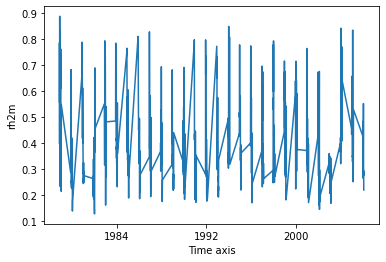

In [143]:
Irh.plot()


#  LMDZ inv and inv hilbert

In [144]:
# Read 850 hPa t
I_tLevData= xr.open_dataset('../../../Data/LMDZ_Data/LMDZOR-HIST-t850_DecJan_1979_2005_1D_histday.nc')
I_tLevData=I_tLevData.assign_coords(time=("time_counter", time1))

It850D=I_tLevData.sel(lat=slice(32,24),lon=slice(74,86))
It850D.t850.values=It850D.t850.values*Imask
# Calculate inv
Iinv = It2mD.t2m.values-It850D.t850.values
Iinv_ds = xr.Dataset({'Iinv': (('time_counter','lat','lon'), Iinv)}, coords={'time_counter': Iv10D.time_counter,'lat': Iv10D.lat,'lon': Iv10D.lon})
#Iinv_ds.Iinv
#Mask
Iinv_ds.Iinv.values=Iinv_ds.Iinv.values*Imask
# area avg
IinvTS=Iinv_ds.mean(dim=['lat','lon'], skipna=True).Iinv

#Select Dec and Jan
Iinv=IinvTS[((IinvTS.time.dt.month>11) | (IinvTS.time.dt.month<2))] 




# LMDZ w700 and w700 hilbert

In [145]:
# Read Data
I_w700Data= xr.open_mfdataset('../../../Data/LMDZ_Data/LMDZOR-HIST-w700_DecJan_1979_2005_1D_histday.nc')
I_w700Data=I_w700Data.assign_coords(time=("time_counter", time1))

Iw700D = I_w700Data.sel(lat=slice(32,24),lon=slice(74,86))
#Mask data
Iw700D.w700.values=Iw700D.w700.values*Imask
# area avg
Iw700TS=Iw700D.mean(dim=['lat','lon'], skipna=True).w700

#ISelect only Dec Jan months
Iw700=Iw700TS[((Iw700TS.time.dt.month>11) | (Iw700TS.time.dt.month<2))]


# LMDZ ushear and ushear hilbert

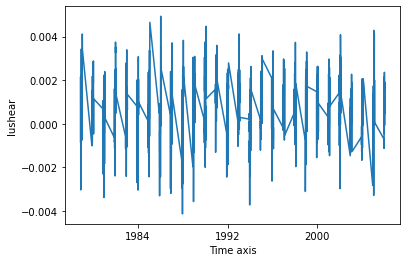

In [146]:
# Read 850 hPa u 
I_uLevData= xr.open_dataset('../../../Data/LMDZ_Data/LMDZOR-HIST-u850_DecJan_1979_2005_1D_histday.nc')
I_uLevData=I_uLevData.assign_coords(time=("time_counter", time1))

Iu850D=I_uLevData.sel(lat=slice(32,24),lon=slice(74,86))
# Read 850 hPa  z 
I_zLevData= xr.open_dataset('../../../Data/LMDZ_Data/LMDZOR-HIST-z850_DecJan_1979_2005_1D_histday.nc')
I_zLevData=I_zLevData.assign_coords(time=("time_counter", time1))

Iz850D=I_zLevData.sel(lat=slice(32,24),lon=slice(74,86))
# Calculate ushear
Iushear = (Iu850D.u850.values-Iu10D.u10m.values)/(Iz850D.z850.values) 
Iushear_ds = xr.Dataset({'Iushear': (('time_counter','lat','lon'), Iushear)}, coords={'time_counter': Iv10D.time_counter,'lat': Iv10D.lat,'lon': Iv10D.lon})
#Iushear_ds.Iushear[0,:,:].plot()
#Mask
Iushear_ds.Iushear.values=Iushear_ds.Iushear.values*Imask
# area avg
IushearTS=Iushear_ds.mean(dim=['lat','lon'], skipna=True).Iushear
#Select Dec and Jan
Iushear=IushearTS[((IushearTS.time.dt.month>11) | (IushearTS.time.dt.month<2))] 
Iushear.plot()

In [147]:
#IX       = pd.DataFrame([It2m.values,Iws.values,Irh.values,Iinv.values,Iw700.values,Iushear.values*100.0,
#                       It2mhb.values,Iwshb.values,Irhhb.values,Iinvhb.values,Iw700hb.values,Iushearhb.values]).T[:]
IX       = pd.DataFrame([It2m.values,Iws.values,Irh.values,Iinv.values,Iw700.values,Iushear.values*100.0]).T[:]



IX.index = pd.to_datetime(time1.values)
IX

,0,1,2,3,4,5
1978-12-01 12:00:00,290.659546,1.456089,0.556800,4.649222,-0.047286,-0.084105
1978-12-02 12:00:00,290.996521,2.274819,0.765484,4.549608,-0.301729,0.027871
1978-12-03 12:00:00,290.903076,1.519300,0.784949,5.305244,-0.087044,0.215887
1978-12-04 12:00:00,289.091827,1.530782,0.714110,5.585198,-0.014797,0.164807
1978-12-05 12:00:00,286.072693,2.379213,0.534079,4.091046,0.151192,0.082044
...,...,...,...,...,...,...
2005-12-27 12:00:00,287.752625,2.084221,0.274734,3.329431,0.046147,0.116342
2005-12-28 12:00:00,287.820129,1.506595,0.242423,3.368390,0.046663,0.046344
2005-12-29 12:00:00,287.334137,1.709938,0.234365,2.043352,0.047813,0.128051
2005-12-30 12:00:00,287.043732,2.350509,0.232332,0.471475,0.050270,0.190472


In [148]:
normI = StandardScaler().fit(IX)
    # transform training data
IX = normI.transform(IX)
IX

array([[ 1.19593799, -0.36143552,  0.94935926,  0.46071559, -1.0844644 ,
        -1.21177366],
       [ 1.38997947,  1.14417343,  2.30832431,  0.39795813, -4.92164846,
        -0.37004113],
       [ 1.33617083, -0.24519345,  2.43508134,  0.87401538, -1.68405128,
         1.04328986],
       ...,
       [-0.71894315,  0.10538101, -1.15035374, -1.18100454,  0.34970175,
         0.38302087],
       [-0.88616817,  1.28336419, -1.16359331, -2.17130077,  0.38674153,
         0.85224628],
       [-0.50471025,  1.13123107, -1.25008901, -2.01513604,  0.60300412,
         0.51595879]])

In [149]:
reg = load('regGB_ObsLMDZ.joblib') 
reg

GradientBoostingRegressor(learning_rate=0.04, min_samples_leaf=20,
                          n_estimators=300, random_state=0)

In [150]:
regLin=load('regLR_ObsLMDZ.joblib')
regLin

LinearRegression()

In [151]:
y_ds=load('y_ds_ObsLMDZ.joblib')
y_ds

<xarray.Dataset>
Dimensions:  (time: 1612)
Coordinates:
    expver   float64 1.0
  * time     (time) datetime64[ns] 1980-01-01T10:30:00 ... 2005-12-31T10:30:00
Data variables:
    y        (time) float64 0.32 0.4 0.4 0.36 0.32 ... 0.16 0.52 0.56 0.6 0.52

In [152]:
y_pred_ds=load('y_pred_ds_ObsLMDZ.joblib')
y_pred_ds

<xarray.Dataset>
Dimensions:  (time: 1612)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2005-12-31
Data variables:
    y_pred   (time) float64 0.1718 0.259 0.2908 0.4148 ... 0.3389 0.3102 0.2825

In [153]:
y_predLin_ds=load('y_predLin_ds_ObsLMDZ.joblib')
y_predLin_ds

<xarray.Dataset>
Dimensions:    (time: 1612)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2005-12-31
Data variables:
    y_predLin  (time) float64 0.2637 0.3745 0.3839 ... 0.2855 0.2515 0.2493

In [154]:
Iy_pred=reg.predict(IX)
Iy_predLin=regLin.predict(IX)
Iy_df = pd.DataFrame(Iy_pred)
Iy_df.index = pd.to_datetime(time1.values)
Iy_dfLin = pd.DataFrame(Iy_predLin)
Iy_dfLin.index = pd.to_datetime(time1.values)

In [155]:
Iy_ds=xr.Dataset({'Iy_pred': (('time'), Iy_pred)}, coords={'time': time1})
Iy_ds

IyLin_ds=xr.Dataset({'Iy_predLin': (('time'), Iy_predLin)}, coords={'time': time1})
IyLin_ds

<xarray.Dataset>
Dimensions:     (time: 1705)
Coordinates:
  * time        (time) datetime64[ns] 1978-12-01T12:00:00 ... 2005-12-31T12:0...
Data variables:
    Iy_predLin  (time) float64 0.2874 0.2589 0.4499 ... 0.1962 0.1982 0.1808

(0.8255762492372871, 0.0)

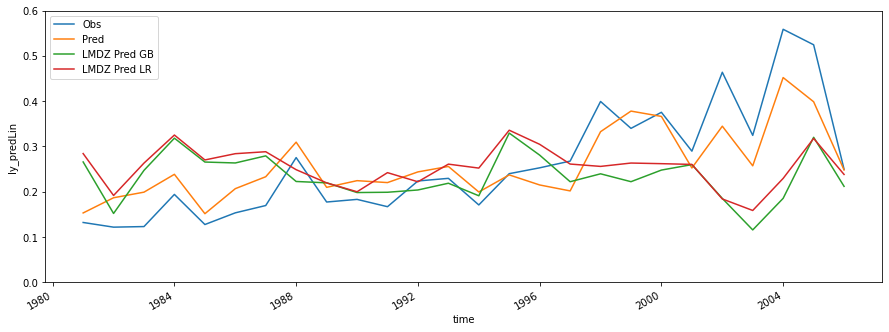

In [157]:
plt.figure(figsize=[15,5])
y_ds.resample(time='1Y').mean().y.dropna(dim='time').plot(label='Obs')
y_pred_ds.resample(time='1Y').mean().y_pred.dropna(dim='time').plot(label='Pred')


Iy_ds.resample(time='1Y').mean().Iy_pred.dropna(dim='time')[2:].plot(label='LMDZ Pred GB')
IyLin_ds.resample(time='1Y').mean().Iy_predLin.dropna(dim='time')[2:].plot(label='LMDZ Pred LR')
plt.ylim(0, 0.6)
plt.legend()
plt.savefig('../LMDZ_yearly.jpeg',dpi=300)
np.corrcoef(y_ds.y.values, y_pred_ds.y_pred.values)
stats.pearsonr(y_ds.y.values, y_pred_ds.y_pred.values)

#y_ds.y.values.corr(y_pred_ds.y_pred.values)

In [158]:
print(np.corrcoef(y_ds.resample(time='1Y').mean().y,Iy_ds.resample(time='1Y').mean().Iy_pred[2:]))
print(np.corrcoef(y_ds.resample(time='1Y').mean().y,IyLin_ds.resample(time='1Y').mean().Iy_predLin[2:]))

[[ 1.         -0.05377985]
 [-0.05377985  1.        ]]
[[ 1.         -0.08453483]
 [-0.08453483  1.        ]]


In [189]:
Widespread_Iy_pred=Iy_ds.Iy_pred.where(Iy_ds.Iy_pred > 0.44, drop=True)
# Total number of widespread fog days
print(Widespread_Iy_pred.sel(time=slice('1980-1-1','2005-12-31')).count())
# mean annual frequency
print(Iy_ds.Iy_pred.sel(time=slice('1980-1-1','2005-12-31')).where(Iy_ds.Iy_pred > 0.44).resample(time='1Y').count().mean())
# interannual std 
print(Iy_ds.Iy_pred.sel(time=slice('1980-1-1','2005-12-31')).where(Iy_ds.Iy_pred > 0.44).resample(time='1Y').count().std())
#Widespread_y_pred.resample(time='1Y').count()

<xarray.DataArray 'Iy_pred' ()>
array(65)
<xarray.DataArray 'Iy_pred' ()>
array(2.5)
<xarray.DataArray 'Iy_pred' ()>
array(2.84537411)


In [191]:
Widespread_Iy_predLin=IyLin_ds.Iy_predLin.where(IyLin_ds.Iy_predLin > 0.44, drop=True)
# Total number of widespread fog days
print(Widespread_Iy_predLin.sel(time=slice('1980-1-1','2005-12-31')).count())
# mean annual frequency
print(IyLin_ds.Iy_predLin.sel(time=slice('1980-1-1','2005-12-31')).where(IyLin_ds.Iy_predLin > 0.44).resample(time='1Y').count().mean())
# interannual std 
print(IyLin_ds.Iy_predLin.sel(time=slice('1980-1-1','2005-12-31')).where(IyLin_ds.Iy_predLin > 0.44).resample(time='1Y').count().std())
#Widespread_y_pred.resample(time='1Y').count()

<xarray.DataArray 'Iy_predLin' ()>
array(99)
<xarray.DataArray 'Iy_predLin' ()>
array(3.80769231)
<xarray.DataArray 'Iy_predLin' ()>
array(2.84225304)


(0.8255762492372871, 0.0)

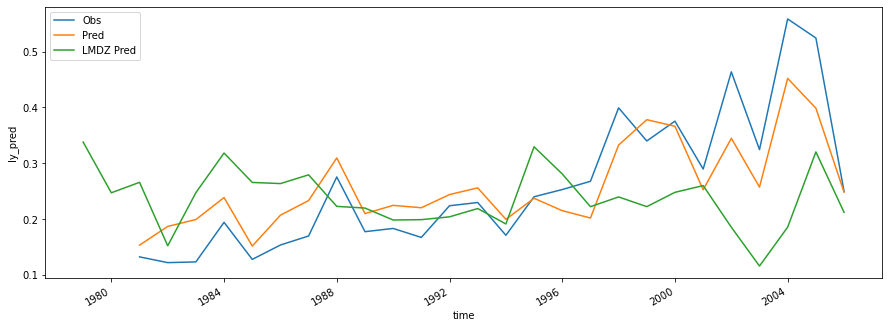

In [159]:
plt.figure(figsize=[15,5])
y_ds.resample(time='1Y').mean().y.dropna(dim='time').plot(label='Obs')
y_pred_ds.resample(time='1Y').mean().y_pred.dropna(dim='time').plot(label='Pred')
Iy_ds.resample(time='1Y').mean().Iy_pred.dropna(dim='time').plot(label='LMDZ Pred')


plt.legend()
np.corrcoef(y_ds.y.values, y_pred_ds.y_pred.values)
stats.pearsonr(y_ds.y.values, y_pred_ds.y_pred.values)

obsTs=y_ds.resample(time='1M').mean().y.dropna(dim='time')
time1=obsTs["time"].dt.strftime("%m-%Y")
obsTs1=obsTs.assign_coords(time=("time", time1))


GBTs=Iy_ds.resample(time='1M').mean().Iy_pred.dropna(dim='time')[259:]
timeGB=GBTs["time"].dt.strftime("%m-%Y")
GBTs1=GBTs.assign_coords(time=("time", timeGB))
GBTs1

LinTs=IyLin_ds.resample(time='1M').mean().Iy_predLin.dropna(dim='time')[259:]
timeLin=LinTs["time"].dt.strftime("%m-%Y")
LinTs1=LinTs.assign_coords(time=("time", timeGB))
LinTs1



plt.figure(figsize=[15,5])
plt.plot(obsTs1.time.values,obsTs1.values,label='Obs')
plt.plot(GBTs1.time.values,GBTs1.values,label='GB_GFDL')
plt.plot(LinTs1.time.values,LinTs1.values,label='LR_GFDL')
plt.xticks(rotation=90)
plt.legend() 
#y_ds1.y.plot()

obsTs=y_ds.resample(time='1Y').mean().y.dropna(dim='time')
time1=obsTs["time"].dt.strftime("%Y")
obsTs1=obsTs.assign_coords(time=("time", time1))


GBTs=Iy_ds.resample(time='1Y').mean().Iy_pred.dropna(dim='time')[259:]
timeGB=GBTs["time"].dt.strftime("%Y")
GBTs1=GBTs.assign_coords(time=("time", timeGB))
GBTs1

LinTs=IyLin_ds.resample(time='1Y').mean().Iy_predLin.dropna(dim='time')[259:]
timeLin=LinTs["time"].dt.strftime("%Y")
LinTs1=LinTs.assign_coords(time=("time", timeGB))
LinTs1



plt.figure(figsize=[15,5])
plt.plot(obsTs1.time.values,obsTs1.values,label='Obs')
plt.plot(GBTs1.time.values,GBTs1.values,label='GB_GFDL')
plt.plot(LinTs1.time.values,LinTs1.values,label='LR_GFDL')
plt.xticks(rotation=90)
plt.legend() 
#y_ds1.y.plot()

In [160]:
# Read z500 data
# Read 850 hPa  z 
Iz500Data_Orig= xr.open_dataset('../../../Data/LMDZ_Data/LMDZOR-HIST-z500_DecJan_1979_2005_1D_histday.nc')
Iz500Data_Orig=Iz500Data_Orig.assign_coords(time=("time_counter", time1))


#Iz500Data


# Calculate anomalies

In [161]:
Iz500Data_Orig.groupby("time.dayofyear").mean("time_counter")

<xarray.Dataset>
Dimensions:    (dayofyear: 63, lat: 181, lon: 360)
Coordinates:
  * lon        (lon) float32 -178.9 -176.7 -174.3 -171.9 ... 175.1 177.0 179.0
  * lat        (lat) float32 90.0 86.49 83.01 79.61 ... -82.91 -86.46 -90.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    z500       (dayofyear, lat, lon) float32 4.986e+03 4.986e+03 ... 5.318e+03

In [162]:
climatology = Iz500Data_Orig.groupby("time.dayofyear").mean("time_counter")
Iz500Data = Iz500Data_Orig.groupby("time.dayofyear") - climatology
#climatology
Iz500Data.time

<xarray.DataArray 'time' (time_counter: 1705)>
array(['1978-12-01T12:00:00.000000000', '1978-12-02T12:00:00.000000000',
       '1978-12-03T12:00:00.000000000', ...,
       '2005-12-29T12:00:00.000000000', '2005-12-30T12:00:00.000000000',
       '2005-12-31T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time_counter  (time_counter) object 1978-12-01 12:00:00 ... 2005-12-31 12...
    time          (time_counter) datetime64[ns] 1978-12-01T12:00:00 ... 2005-...
    dayofyear     (time_counter) int64 335 336 337 338 339 ... 362 363 364 365

In [193]:
Iy_ds.Iy_pred
Widespread_Iy1=Iy_ds.Iy_pred.where(Iy_ds.Iy_pred > 0.44, drop=True)
Widespread_Iy=Widespread_Iy1.sel(time=slice('1980-1-1','2005-12-31'))
totalCnt=Widespread_Iy.time.sizes
totalCnt

Frozen({'time': 65})

In [164]:
timeWD=Widespread_Iy.time
timeWD

<xarray.DataArray 'time' (time: 65)>
array(['1980-12-14T12:00:00.000000000', '1980-12-18T12:00:00.000000000',
       '1980-12-23T12:00:00.000000000', '1980-12-24T12:00:00.000000000',
       '1980-12-25T12:00:00.000000000', '1980-12-26T12:00:00.000000000',
       '1980-12-27T12:00:00.000000000', '1980-12-31T12:00:00.000000000',
       '1981-01-01T12:00:00.000000000', '1982-12-16T12:00:00.000000000',
       '1982-12-17T12:00:00.000000000', '1982-12-22T12:00:00.000000000',
       '1982-12-24T12:00:00.000000000', '1982-12-25T12:00:00.000000000',
       '1982-12-26T12:00:00.000000000', '1982-12-27T12:00:00.000000000',
       '1982-12-28T12:00:00.000000000', '1982-12-31T12:00:00.000000000',
       '1983-01-01T12:00:00.000000000', '1983-01-02T12:00:00.000000000',
       '1983-01-03T12:00:00.000000000', '1983-01-04T12:00:00.000000000',
       '1983-01-05T12:00:00.000000000', '1983-01-06T12:00:00.000000000',
       '1983-12-05T12:00:00.000000000', '1983-12-06T12:00:00.000000000',
       '1983-12-15T12:00:00.000000000', '1983-12-19T12:00:00.000000000',
       '1984-12-04T12:00:00.000000000', '1984-12-05T12:00:00.000000000',
       '1984-12-20T12:00:00.000000000', '1985-12-13T12:00:00.000000000',
       '1986-12-06T12:00:00.000000000', '1986-12-07T12:00:00.000000000',
       '1986-12-13T12:00:00.000000000', '1987-12-29T12:00:00.000000000',
       '1990-12-04T12:00:00.000000000', '1990-12-05T12:00:00.000000000',
       '1992-12-02T12:00:00.000000000', '1992-12-03T12:00:00.000000000',
       '1993-12-30T12:00:00.000000000', '1994-01-01T12:00:00.000000000',
       '1994-01-23T12:00:00.000000000', '1994-12-17T12:00:00.000000000',
       '1994-12-18T12:00:00.000000000', '1995-01-05T12:00:00.000000000',
       '1995-12-14T12:00:00.000000000', '1995-12-30T12:00:00.000000000',
       '1996-12-23T12:00:00.000000000', '1997-12-16T12:00:00.000000000',
       '1997-12-17T12:00:00.000000000', '1997-12-21T12:00:00.000000000',
       '1997-12-22T12:00:00.000000000', '1997-12-23T12:00:00.000000000',
       '1997-12-25T12:00:00.000000000', '1999-12-26T12:00:00.000000000',
       '2003-12-23T12:00:00.000000000', '2004-01-17T12:00:00.000000000',
       '2004-01-18T12:00:00.000000000', '2004-01-19T12:00:00.000000000',
       '2004-12-04T12:00:00.000000000', '2004-12-16T12:00:00.000000000',
       '2005-01-02T12:00:00.000000000', '2005-01-05T12:00:00.000000000',
       '2005-01-06T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1980-12-14T12:00:00 ... 2005-01-06T12:00:00

In [165]:
zTest=xr.Dataset({'zg': (('time','lat','lon'), Iz500Data.z500)}, coords={'time': time1,'lat': Iz500Data.lat,'lon': Iz500Data.lon})
zTest
zwide=zTest.sel(time=Widespread_Iy.time,method="nearest")
zwide

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360, time: 65)
Coordinates:
  * time     (time) datetime64[ns] 1980-12-14T12:00:00 ... 2005-01-06T12:00:00
  * lat      (lat) float32 90.0 86.49 83.01 79.61 ... -79.37 -82.91 -86.46 -90.0
  * lon      (lon) float32 -178.9 -176.7 -174.3 -171.9 ... 175.1 177.0 179.0
Data variables:
    zg       (time, lat, lon) float32 -164.5 -164.5 -164.5 ... 76.47 76.47 76.47

In [166]:
zwidePos=zwide.zg.where(zwide.zg.sel(lat=slice(40,20),lon=slice(60,85)).mean(dim=['lat','lon']) > 0.0, drop=True)
PosCnt=zwidePos.time.sizes
PosCnt

Frozen({'time': 32})

In [167]:
zwideNeg=zwide.zg.where(zwide.zg.sel(lat=slice(40,20),lon=slice(60,85)).mean(dim=['lat','lon']) < 0.0, drop=True)
NegCnt=zwideNeg.time.sizes

In [168]:
zwideAll=zwide.zg.sel(lat=slice(70,0),lon=slice(20,150)).mean(dim='time')
#zwideAll

In [169]:
zNeg=zwideNeg.sel(lat=slice(70,0),lon=slice(20,150)).mean(dim='time')
#zNeg

zPos=zwidePos.sel(lat=slice(70,0),lon=slice(20,150)).mean(dim='time')
#zPos

In [170]:
zwideNeg

<xarray.DataArray 'zg' (time: 33, lat: 181, lon: 360)>
array([[[  32.67041 ,   32.67041 ,   32.67041 , ...,   32.67041 ,
           32.67041 ,   32.67041 ],
        [  66.24756 ,   67.28955 ,   68.350586, ...,   63.20459 ,
           64.20557 ,   65.220215],
        [  70.43994 ,   72.61621 ,   74.913086, ...,   64.63086 ,
           66.46826 ,   68.395996],
        ...,
        [ -43.354004,  -41.675293,  -39.811035, ...,  -47.29492 ,
          -46.16748 ,  -44.893555],
        [ -34.444336,  -33.27881 ,  -32.112305, ...,  -37.686523,
          -36.672363,  -35.578125],
        [ -49.2041  ,  -49.2041  ,  -49.2041  , ...,  -49.2041  ,
          -49.2041  ,  -49.2041  ]],

       [[ 321.2412  ,  321.2412  ,  321.2412  , ...,  321.2412  ,
          321.2412  ,  321.2412  ],
        [ 405.26807 ,  404.73682 ,  403.94092 , ...,  405.68652 ,
          405.70654 ,  405.57764 ],
        [ 471.66504 ,  472.85205 ,  473.61426 , ...,  466.30273 ,
          468.32617 ,  470.1338  ],
...
        [  69.55469 ,   72.8457  ,   75.90576 , ...,   59.472656,
           62.592285,   66.07568 ],
        [  59.983887,   61.459473,   62.98242 , ...,   56.2417  ,
           57.37256 ,   58.62451 ],
        [  67.57861 ,   67.57861 ,   67.57861 , ...,   67.57861 ,
           67.57861 ,   67.57861 ]],

       [[-104.00488 , -104.00488 , -104.00488 , ..., -104.00488 ,
         -104.00488 , -104.00488 ],
        [ -89.56592 ,  -89.461426,  -89.51904 , ...,  -90.53613 ,
          -90.13281 ,  -89.80127 ],
        [ -65.81201 ,  -64.79248 ,  -64.10156 , ...,  -70.25928 ,
          -68.58887 ,  -67.0957  ],
        ...,
        [ 155.89648 ,  158.51123 ,  160.59766 , ...,  146.73096 ,
          149.52637 ,  152.7456  ],
        [ 111.89307 ,  113.90918 ,  115.76514 , ...,  106.6416  ,
          108.27539 ,  110.01953 ],
        [  76.46631 ,   76.46631 ,   76.46631 , ...,   76.46631 ,
           76.46631 ,   76.46631 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-12-18T12:00:00 ... 2005-01-06T12:00:00
  * lat      (lat) float32 90.0 86.49 83.01 79.61 ... -79.37 -82.91 -86.46 -90.0
  * lon      (lon) float32 -178.9 -176.7 -174.3 -171.9 ... 175.1 177.0 179.0

In [171]:
zwidePos

<xarray.DataArray 'zg' (time: 32, lat: 181, lon: 360)>
array([[[-1.64484375e+02, -1.64484375e+02, -1.64484375e+02, ...,
         -1.64484375e+02, -1.64484375e+02, -1.64484375e+02],
        [-1.45107910e+02, -1.45964844e+02, -1.46731934e+02, ...,
         -1.42303223e+02, -1.43249512e+02, -1.44193359e+02],
        [-1.01423340e+02, -1.04259766e+02, -1.07193359e+02, ...,
         -9.35903320e+01, -9.60742188e+01, -9.86909180e+01],
        ...,
        [-2.75708008e+01, -2.77055664e+01, -2.77812500e+01, ...,
         -2.71718750e+01, -2.71977539e+01, -2.73745117e+01],
        [-4.08901367e+01, -4.06284180e+01, -4.04624023e+01, ...,
         -4.19213867e+01, -4.15278320e+01, -4.11777344e+01],
        [-7.55917969e+01, -7.55917969e+01, -7.55917969e+01, ...,
         -7.55917969e+01, -7.55917969e+01, -7.55917969e+01]],

       [[-6.08085938e+01, -6.08085938e+01, -6.08085938e+01, ...,
         -6.08085938e+01, -6.08085938e+01, -6.08085938e+01],
        [-4.26757812e+01, -4.18310547e+01, -4.10317383e+01, ...,
         -4.54062500e+01, -4.44731445e+01, -4.35590820e+01],
        [ 6.47714844e+01,  6.82021484e+01,  7.15151367e+01, ...,
          5.40654297e+01,  5.76748047e+01,  6.12548828e+01],
...
          1.01352539e+02,  9.91889648e+01,  9.71630859e+01],
        [ 1.63942871e+02,  1.63080078e+02,  1.62011230e+02, ...,
          1.67143555e+02,  1.65799316e+02,  1.64805176e+02],
        [ 2.46196777e+02,  2.46196777e+02,  2.46196777e+02, ...,
          2.46196777e+02,  2.46196777e+02,  2.46196777e+02]],

       [[-2.09814453e+02, -2.09814453e+02, -2.09814453e+02, ...,
         -2.09814453e+02, -2.09814453e+02, -2.09814453e+02],
        [-1.67026855e+02, -1.67592773e+02, -1.68350586e+02, ...,
         -1.66368164e+02, -1.66428711e+02, -1.66643555e+02],
        [-1.25324707e+02, -1.26365234e+02, -1.27909180e+02, ...,
         -1.24576660e+02, -1.24479492e+02, -1.24713867e+02],
        ...,
        [ 4.57636719e+01,  4.82275391e+01,  5.04995117e+01, ...,
          3.75029297e+01,  4.03115234e+01,  4.31191406e+01],
        [ 2.96376953e+01,  3.09897461e+01,  3.24477539e+01, ...,
          2.55522461e+01,  2.69501953e+01,  2.82993164e+01],
        [ 1.42592773e+01,  1.42592773e+01,  1.42592773e+01, ...,
          1.42592773e+01,  1.42592773e+01,  1.42592773e+01]]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-12-14T12:00:00 ... 2004-12-16T12:00:00
  * lat      (lat) float32 90.0 86.49 83.01 79.61 ... -79.37 -82.91 -86.46 -90.0
  * lon      (lon) float32 -178.9 -176.7 -174.3 -171.9 ... 175.1 177.0 179.0

In [172]:
def map_plot(ax1):
    ax1.coastlines()
    ax1.set_xticks([20,40 , 60,80, 100,120, 140], crs=ccrs.PlateCarree())
    ax1.set_yticks([ 10, 20, 30, 40, 50, 60,70], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)

In [173]:
# for contour labels
delta = 5.0
x = np.arange(-60, 60, delta)
y = np.arange(-60, 60, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2
# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'


class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s


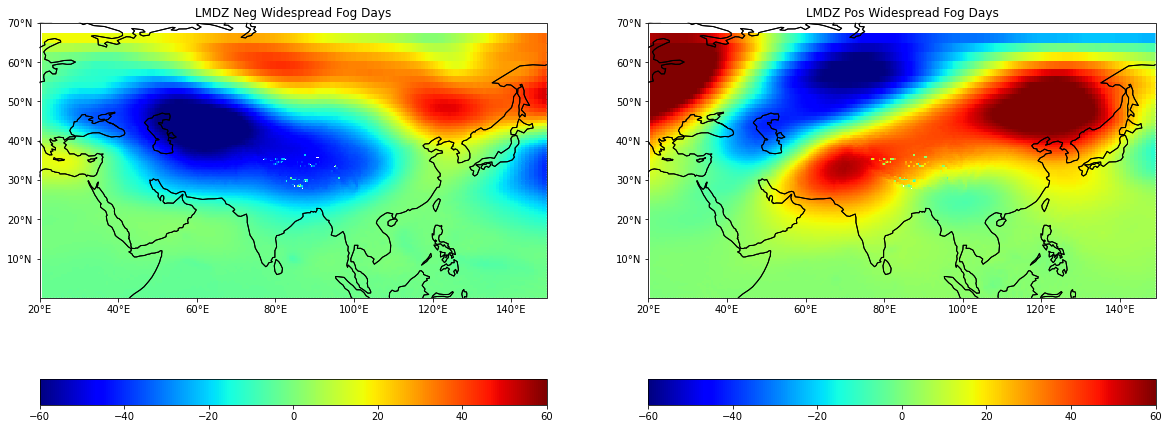

In [176]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.pcolor(zNeg.lon.values,zNeg.lat.values,zNeg,transform=ccrs.PlateCarree(),cmap='jet',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax1)
ax1.coastlines()
ax1.set_title('LMDZ Neg Widespread Fog Days')
fig.colorbar(m1,orientation='horizontal')

ax2 = fig.add_subplot(122,projection=ccrs.PlateCarree())

m2=ax2.pcolor(zPos.lon.values,zPos.lat.values,zPos,transform=ccrs.PlateCarree(),cmap='jet',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax2)
ax2.coastlines()
ax2.set_title('LMDZ Pos Widespread Fog Days')

fig.colorbar(m2,orientation='horizontal')

plt.savefig('../LMDZWDF_pos_Neg.jpeg',dpi=300)


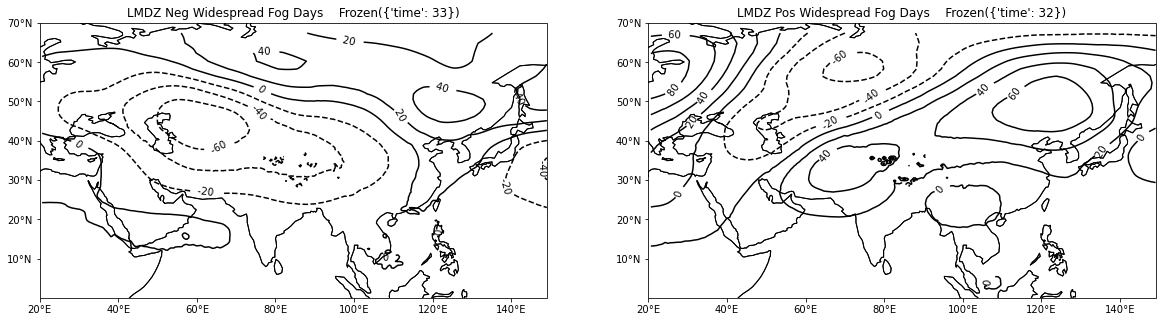

In [177]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.contour(zNeg.lon.values,zNeg.lat.values,zNeg,transform=ccrs.PlateCarree(),colors ='black',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax1)
ax1.coastlines()
# Recast levels to new class
m1.levels = [nf(val) for val in m1.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r '
else:
    fmt = '%r '

ax1.clabel(m1, m1.levels, inline=True, fmt=fmt, fontsize=10)
ax1.set_title('LMDZ Neg Widespread Fog Days'+"    "+str(NegCnt))
#fig.colorbar(m1,orientation='horizontal')


########## second Figure
ax2 = fig.add_subplot(122,projection=ccrs.PlateCarree())
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
m2=ax2.contour(zPos.lon.values,zPos.lat.values,zPos,transform=ccrs.PlateCarree(),colors ='black',vmax=60,vmin=-60)
map_plot(ax2)
ax2.coastlines()

# Recast levels to new class
m2.levels = [nf(val) for val in m2.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r '
else:
    fmt = '%r '

ax2.clabel(m2, m2.levels, inline=True, fmt=fmt, fontsize=10)

ax2.set_title('LMDZ Pos Widespread Fog Days'+"    "+str(PosCnt))

#fig.colorbar(m2,orientation='horizontal')

plt.savefig('../LMDZWDF_pos_Neg.jpeg',dpi=300)


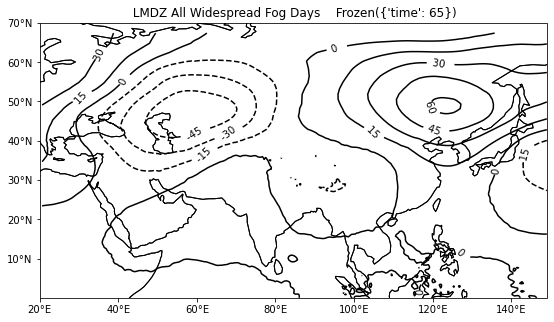

In [178]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.contour(zwideAll.lon.values,zwideAll.lat.values,zwideAll,transform=ccrs.PlateCarree(),colors ='black',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax1)
ax1.coastlines()
# Recast levels to new class
m1.levels = [nf(val) for val in m1.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r '
else:
    fmt = '%r '

ax1.clabel(m1, m1.levels, inline=True, fmt=fmt, fontsize=10)
ax1.set_title(' LMDZ All Widespread Fog Days'+"    "+str(totalCnt) )
#fig.colorbar(m1,orientation='horizontal')
plt.savefig('../LMDZWDF_All.jpeg',dpi=300)

# Read Low level fog Data  

In [179]:
I_lowCloudData= xr.open_dataset('../../../Data/LMDZ_Data/LMDZOR-HIST-rneb_DecJan1979_2005_1D_histday.nc')

In [180]:
time1=I_lowCloudData.indexes['time_counter'].to_datetimeindex()
I_lowCloudData=I_lowCloudData.assign_coords(time=("time", time1))




<ipython-input-180-540552440af8>:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  time1=I_lowCloudData.indexes['time_counter'].to_datetimeindex()


In [181]:
I_lowCloudData.rneb[:,1,:,:]

<xarray.DataArray 'rneb' (time_counter: 1705, lat: 181, lon: 360)>
[111097800 values with dtype=float32]
Coordinates:
  * time_counter  (time_counter) object 1978-12-01 12:00:00 ... 2005-12-31 12...
  * lon           (lon) float32 -178.9 -176.7 -174.3 ... 175.1 177.0 179.0
  * lat           (lat) float32 90.0 86.49 83.01 79.61 ... -82.91 -86.46 -90.0
    presnivs      float32 9.833e+04
Attributes:
    standard_name:       Cloud fraction
    long_name:           Cloud fraction
    units:               -
    online_operation:    ave(X)
    interval_operation:  720.0
    interval_write:      86400.0

In [182]:
clTest=xr.Dataset({'rneb': (('time','lat','lon'), I_lowCloudData.rneb[:,1,:,:])}, coords={'time': time1,'lat': I_lowCloudData.lat,'lon': I_lowCloudData.lon})
clTest

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360, time: 1705)
Coordinates:
  * time     (time) datetime64[ns] 1978-12-01T12:00:00 ... 2005-12-31T12:00:00
  * lat      (lat) float32 90.0 86.49 83.01 79.61 ... -79.37 -82.91 -86.46 -90.0
  * lon      (lon) float32 -178.9 -176.7 -174.3 -171.9 ... 175.1 177.0 179.0
Data variables:
    rneb     (time, lat, lon) float32 0.6388 0.6388 0.6388 ... 0.0 0.0 0.0

In [183]:

cloudwide=clTest.sel(time=Widespread_Iy.time,method="nearest")
#cloudwide

In [184]:
cloudwideAll=cloudwide.rneb.sel(lat=slice(40,5),lon=slice(60,100)).mean(dim='time')
#zwideAll


In [185]:
def map_plot_cloud(ax1):
    ax1.coastlines()
    ax1.set_xticks([70,75 , 80,85, 90,95, 100], crs=ccrs.PlateCarree())
    ax1.set_yticks([10,15 ,20, 25, 30, 35,40], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)

/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


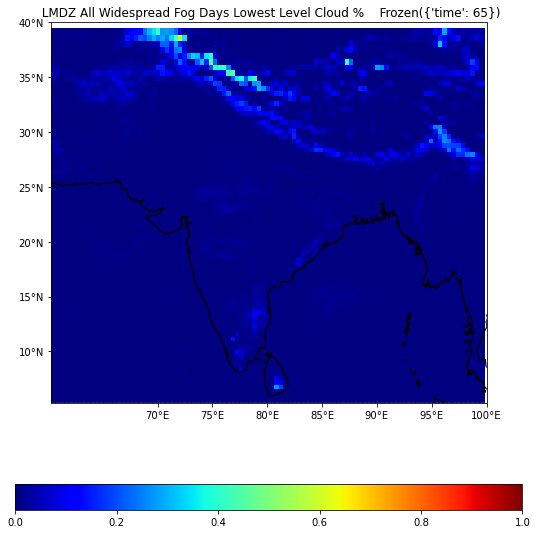

In [186]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.pcolor(cloudwideAll.lon.values,cloudwideAll.lat.values,cloudwideAll,transform=ccrs.PlateCarree(),cmap='jet',vmax=1,vmin=0)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot_cloud(ax1)
ax1.coastlines()
# Recast levels to new class

ax1.set_title(' LMDZ All Widespread Fog Days Lowest Level Cloud %'+"    "+str(totalCnt) )
fig.colorbar(m1,orientation='horizontal')
#fig.colorbar(m1,orientation='horizontal')
plt.savefig('../LMDZWDF_Cloud_All.jpeg',dpi=300)

In [187]:
cloudwidePos=cloudwide.rneb.where(zwide.zg.sel(lat=slice(40,20),lon=slice(60,85)).mean(dim=['lat','lon']) > 0.0, drop=True)
PosCnt=cloudwidePos.time.sizes


cloudwideNeg=cloudwide.rneb.where(zwide.zg.sel(lat=slice(40,20),lon=slice(60,85)).mean(dim=['lat','lon']) < 0.0, drop=True)
NegCnt=cloudwideNeg.time.sizes


cloudeNeg=cloudwideNeg.sel(lat=slice(40,5),lon=slice(60,100)).mean(dim='time')
#zNeg

cloudePos=cloudwidePos.sel(lat=slice(40,5),lon=slice(60,100)).mean(dim='time')
#zPos


/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


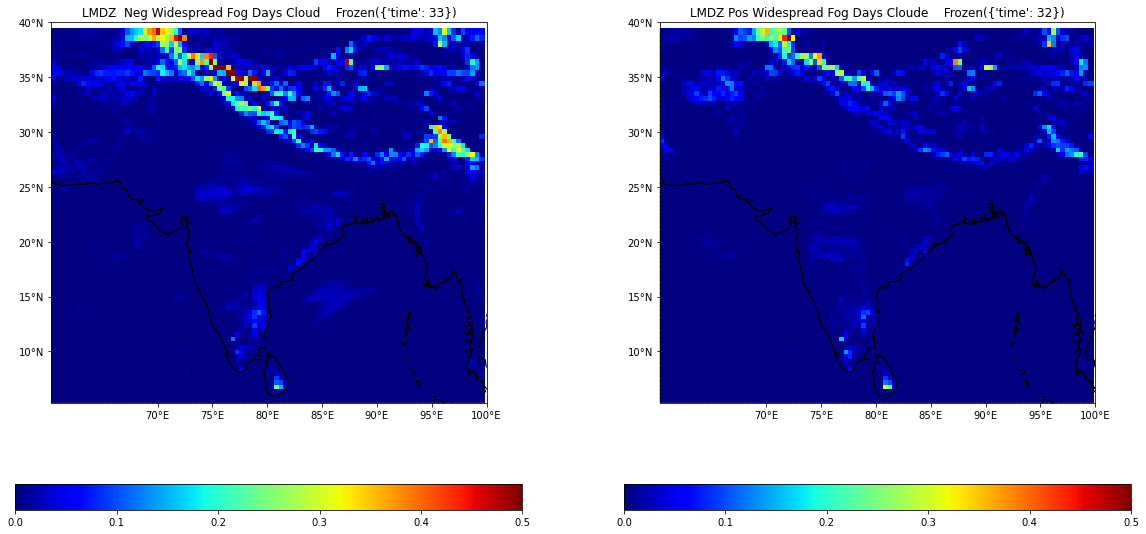

In [188]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.pcolor(cloudeNeg.lon.values,cloudeNeg.lat.values,cloudeNeg,transform=ccrs.PlateCarree(),cmap='jet',vmax=0.5,vmin=0)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot_cloud(ax1)
ax1.coastlines()

ax1.set_title('LMDZ  Neg Widespread Fog Days Cloud'+"    "+str(NegCnt))
#fig.colorbar(m1,orientation='horizontal')

fig.colorbar(m1,orientation='horizontal')
########## second Figure
ax2 = fig.add_subplot(122,projection=ccrs.PlateCarree())
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
m2=ax2.pcolor(cloudePos.lon.values,cloudePos.lat.values,cloudePos,transform=ccrs.PlateCarree(),cmap='jet',vmax=.50,vmin=0)
map_plot_cloud(ax2)
ax2.coastlines()




ax2.set_title('LMDZ Pos Widespread Fog Days Cloude'+"    "+str(PosCnt))
fig.colorbar(m2,orientation='horizontal')
#fig.colorbar(m2,orientation='horizontal')

plt.savefig('../LMDZWDF_pos_Neg_cloud.jpeg',dpi=300)
